# <span style='font-family:Inter Black'> Index Deep Dive

## <span style='font-family:Inter'> Anatomy

In [1]:
import os
import sys

sys.path.insert(0, 'C:\\Users\\lucab\\PycharmProjects\\Warehouse')

In [2]:
from primitive import *

In [3]:
index_name = 'dow_jones'
df = get_dow_jones()
dj = df.loc[:, index_name]
dj_ret = dj.pct_change()
dj_log_ret = np.log(dj) - np.log(dj.shift(1))

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\lucab\\PycharmProjects\\Warehouse\\djindus.xlsx'

In [ ]:
fig = plt.figure(figsize=(13, 10))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.set_title(index_name + ' equity line', fontsize=15)
ax2.set_title(index_name + ' equity line (log scale)', fontsize=15)
ax3.set_title(index_name + ' daily returns', fontsize=15)
dj.plot(ax=ax1, color='blue', linewidth=1)
dj.plot(ax=ax2, color='blue', linewidth=1, logy=True)
dj_ret.plot(ax=ax3, color='red', linewidth=0.2)
plt.tight_layout()
plt.show()

## <span style='font-family:Inter'> Log-log vs semi-log plot
  
Then, if plotting the tail of the return distribution on a log log plot resemble a straight line, we can't rule out the possibility hat data come from a power law distribution (Link to [**log-log plot notebook**](../../Notes/StatsAndProbability/LogSemiLogPlot.ipynb))

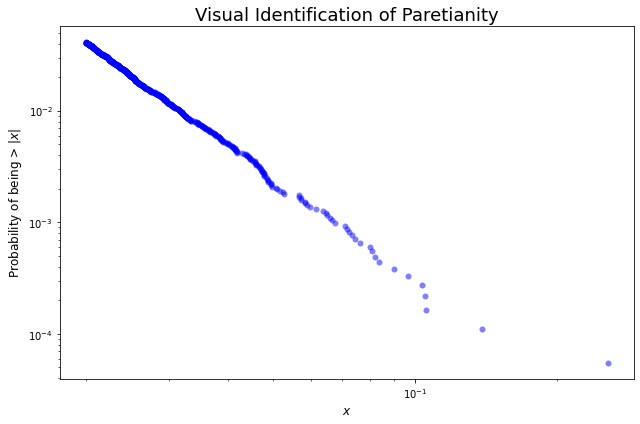

In [5]:
log_log_plot_with_threshold(dj_log_ret, threshold=0.02)

## <span style='font-family:Inter'> Kurtosis Analysis

Relying on the non-convergence of moments, let $\lVert X_p \lVert$ be the weighted p-norm

$$
\lVert X_p \lVert \triangleq (\frac{1}{n} \sum_{i=1}^{n}||x||_p)^\frac{1}{p}
$$

we have the property of power laws $E(Xp) ≮  \infty \Leftrightarrow ∥x∥_p$ is not convergent. First, let's check if the fourth moment of the daily returns are converging.

In [6]:
kurt_original = pd.Series(lagging_kurtosis(dj.reset_index().loc[:, 'dow_jones']))

kurt_dict_reshuffled = {}
for k in range(10):
    dj_reshuffled = reshuffled_ts(dj)
    kurt_dict_reshuffled[k] = lagging_kurtosis(dj_reshuffled)

kurt_reshuffled = pd.DataFrame(kurt_dict_reshuffled).mean(axis=1)

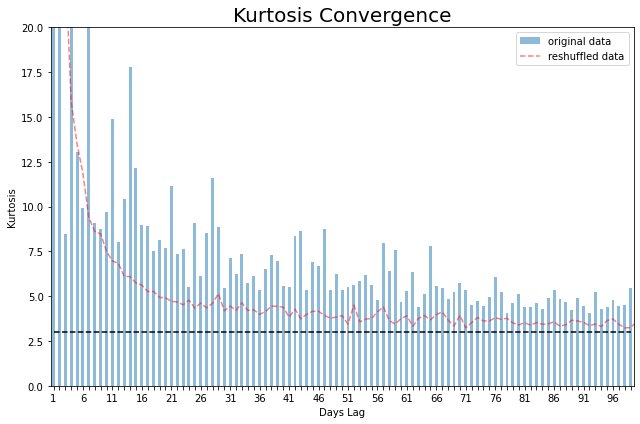

In [9]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)
kurt_reshuffled.name = 'reshuffled data'
kurt_original.name = 'original data'
kurt_original.plot(kind='bar', ax=ax, alpha=0.5,  legend=True)
kurt_reshuffled.plot(ax=ax, style='--', alpha=0.5, color='red', legend=True)
ax.hlines(3, ax.get_xticks().min(), ax.get_xticks().max(), linestyle='--', color='black')
for i, t in enumerate(ax.get_xticklabels()):
    if (i % 5) != 0:
        t.set_visible(False)

ax.set_title('Kurtosis Convergence', fontsize=20)
ax.set_xlabel('Days Lag', fontsize=10)
ax.set_ylabel('Kurtosis', fontsize=10)
ax.set_ylim(0, 20)
plt.tight_layout()
plt.show()

If Kurtosis existed, it would end up converging to that of a Gaussian as one lengthens the time window. Visual convergence diagnostics for the kurtosis of the Dow Jones over the past observations. We compute the kurtosis at different lags for the raw and reshuffled data. While the 4th norm is not convergent **(?)** for raw data, it is clearly so for the reshuffled series. We can thus assume that the "fat tailedness" is attributable to the temporal structure of the data, particularly the clustering of its volatility.

## <span style='font-family:Inter'> Max to Sum Plot 

MS Plot (or "law of large numbers for p moments") for p = 4 for the Dow Jones compared to p = 4 for a Gaussian and stochastic volatility for a matching Kurtosis ( 30) over the entire period. Convergence, if any, does not take place in any reasonable time. MS Plot for moment p = 3 for the SP500 compared to p = 4 for a Gaussian. We can safely say that the 4th moment is infinite and the 3rd one is indeterminate

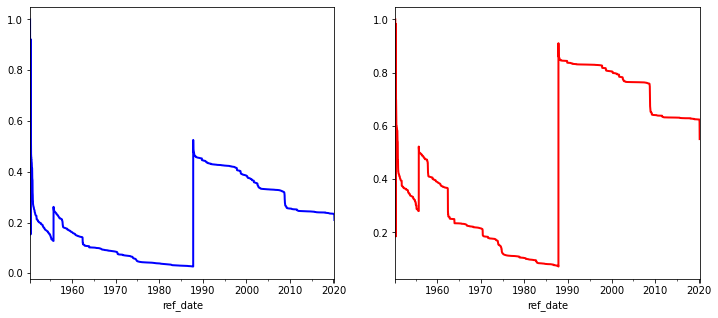

In [8]:
dj_ret_fourth = dj_ret.dropna()**4
dj_ret_third = dj_ret.dropna()**3

max_to_sum_third = abs(dj_ret_third).expanding().max() / abs(dj_ret_third).expanding().sum()
max_to_sum_fourth = dj_ret_fourth.expanding().max() / dj_ret_fourth.expanding().sum()

fig2 = plt.figure(figsize=(12, 5))
ax3 = fig2.add_subplot(121)
ax4 = fig2.add_subplot(122)
max_to_sum_third.plot(ax=ax3, color='blue', linewidth=2)
max_to_sum_fourth.plot(ax=ax4, color='red', linewidth=2)
plt.show()

## <span style='font-family:Inter'> Drawdown Distribution

C:\Users\ilsup\PycharmProjects\Warehouse\Viz\charting.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)
C:\Users\ilsup\PycharmProjects\Warehouse\Viz\charting.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


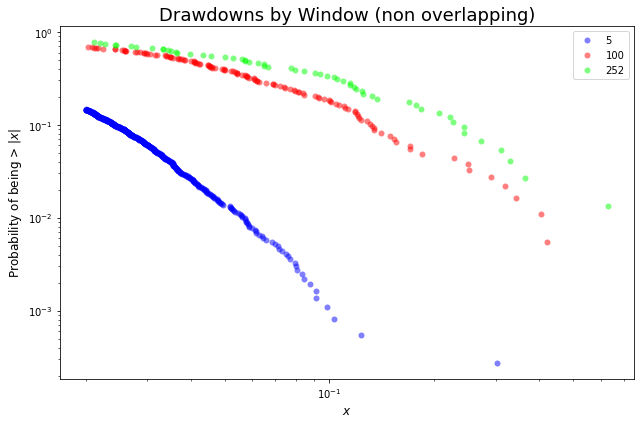

In [9]:
from Finance.drawdowns_distribution import plot_drawdown_by_window
windows = [5, 100, 252]
plot_drawdown_by_window(dj, windows)

## <span style='font-family:Inter'> Conditional Expectation

Let $K$ be in $R^+$, the relative excess conditional expectation:
$$Phi+ K ≜ E(X)jX>K K$$

We have

for distributions outside the power law basin, and

for distribution satisfying Definition 1. Note the van der Wijk’s law [44],[217].
Figure 10.4 shows the following: the conditional expectation does not drop for large
values, which is incompatible with non-Paretian distributions.

In [6]:
sorted_returns = dj_ret.dropna().sort_values(ascending=False).reset_index().loc[:, index_name]
negative_ret = sorted_returns[sorted_returns < 0]
for i in negative_ret.index:
    (negative_ret.loc[i:] * -1).mean(), -negative_ret.loc[i])

SyntaxError: invalid syntax (<ipython-input-6-df258aa45328>, line 4)